# Adaboost 
In this tutorial, I will introduce the Adaboost algorithm. The outline is as follows.
* Introduction
* Algorithm detail
* Sample application
* Algorithm implementation

# Introduction
## Boosting
Boosting is an algorithm to combine multiple weak learning algorithm to a strong learning algorithm. If we use binary classification as examples. Weak classifiers are those which only can achieve a slightly better accuracy than the random guessing by the probability. The boosting ensembles many weak classifiers together, making a strong classifiers. When the multiple weak classifiers are easy to train, which means they can be train with limited computing resource, the boosting will be very useful.

## Adaboost
Adaboost means “Adaptive Boosting”, which first created by Yoav Freund and Robert Schapire in 1995<sup>[1]</sup>. The underlying logic is to assign weights to the data samples. When the model is being trained, the model will assign more weights to data samples which are classified wrongly by the first classifier. Then it will introduce a new weak classifiers and run classification on the updated data samples, untill the mode converge to an accepeted loss or the max iterations. Also, in each iteration, the model will calculate the error rate for each weak classifier. After all iterations, the ensembled strong classifier will be a weighed summary of the weak classifiers, when the weights are calculated by their error rate. Then the classifiers with lower error rate will have a higher weights in the ensembled classifier. <br>
Because the ensembled classifiers are conbinations of weak classifiers, they are less prone to overfitting. Weak classifiers such as one level decision tree are not likely to overfit the training dataset. Also, the ensembled model sometimes can have better accuracy than other strong classifiers. As a result, Adaboost becomes a popular ensembling algorithm in machine learning.


# Algorithm detail
#### Step 1
First, we need to initiate the weights. If we have n data samples, we will assign 1/n to each data sample.
W<sub>1</sub> = (w<sub>11</sub>,w<sub>1j</sub>,...,w<sub>1N</sub>)
#### Step 2
Then, we will iterate I rounds. In each round, we use a new weak classifier<br>
For i = 1,2,...,I: <br>
1. Train the weak classifier L<sub>i</sub>(x)
2. Calculate the error rate of the classifier e<sub>i</sub>
3. Calculate the weight of this weak classifier in the ensembled classifier a<sub>i</sub><br>
In the Yoav Freund's paper, they used $ \frac{1}2log(\frac{1 - {e_i}}{e_i})$. With this equation, the classifiers with lower error rates will have a higher weights in the ensembled classifier. Though this, the ensembled classifier can be more accrate since it tend to rely more on the accurate weak classifier.
4. Update the weights of the data samplesW<sub>i + 1</sub>
In this sub step, we will increase the weights of those samples that are classified wrongly. So the classifier will focus more on the samples that are hard to classify.



#### Step 3   
Finally, we got our ensembled binary classifier. $ sign(\sum_{i = 1}^{I}{a_iL_i(x)}) $

# Sample application
In this section, I will use adaboost to train a classifier to classify if the network incoming trafic is malicious or benign. To analyze malicious traffic, I use the KDD-99 data<sup>[2]</sup>, which is widely used for the evaluation of the traffic classify. The attacks in the KDD-99 data are categorized in four categories. They are denial of service attack, user to root attack, remote to local attack, probing attck, and remote to local attack. Because Adaboost is suitable for binary classification. I will classify the data to malicious (1) or not (-1). <br>
To make the classifications, there are 41 features. It includes some property features such as the protocol, service and so on. it also consits of may behavior features,which are the behavior of the same host or same services. Those features are extracted based on the domain knowledge. We are going to use all of them.
The detail description of the data can be found [here](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)

In [1]:
import pandas as pd
import numpy as np

## Data cleaning and preprocessing
First, I will clean the data and process it to the desired format. Since the data is procurated, I do not need to handle the missing value or outliers. But we still need to prepare the data to the format that the model can consume.

In [2]:
def data_clean(path):
    column = []
    with open("att", 'r') as att:
        for line in att:
            column.append(line.split(":")[0])
    column.extend(['label','category'])
    match_dict = {'normal':'normal'}
    with open ("training_attack_types", 'r') as match:
        for line in match:
            temp = line.split(" ")
            if len(temp) != 2:
                continue
            match_dict[temp[0].strip()] = temp[1].strip()
    data = pd.read_csv(path,names = column)
    data['category'] = data['label'].apply(lambda x: match_dict[x.strip('.')] if x.strip('.') in match_dict else None)
    data = data.drop('label',1)
    data = data.drop('service',1)
    data = data[data.category.notnull()]
    return data

In [23]:
# First, download the data from object storage
train = data_clean('https://objectstorage.us-ashburn-1.oraclecloud.com/n/bestat/b/davidtesting/o/train2.csv')
test = data_clean('https://objectstorage.us-ashburn-1.oraclecloud.com/n/bestat/b/davidtesting/o/test.csv')

In [24]:
train.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,category
0,0,tcp,SF,491,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,SF,146,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,S0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,tcp,SF,232,8153,0,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,SF,199,420,0,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [8]:
test = test.reset_index(drop=True)
test.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,category
0,0,udp,SF,105,146,0,0,0,0,0,...,254,1.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,0,udp,SF,105,146,0,0,0,0,0,...,254,1.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal
2,0,udp,SF,105,146,0,0,0,0,0,...,254,1.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal
3,0,udp,SF,29,0,0,0,0,0,0,...,3,0.30,0.30,0.3,0.0,0.0,0.0,0.0,0.0,normal
4,0,udp,SF,105,146,0,0,0,0,0,...,253,0.99,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal


The columns of the data is as follows. We notice the "protocol_type", "flag", "land", and "service" are categorical variables. We need to change them to dummy variables.

In [6]:
train.columns

Index(['duration', 'protocol_type', 'flag', 'src_bytes', 'dst_bytes', 'land',
       'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'category'],
      dtype='object')

After that the category will be processed to +1 and -1 as the binary class.

In [25]:
train['category'] = train['category'].apply(lambda x: -1 if x == 'normal' else 1)
test['category'] = test['category'].apply(lambda x: -1 if x == 'normal' else 1)

Then we need to check if the data is imbalanced. Imbalanced data can lead to bias in binary classification problem. In this dataset, we notice the data is almost balanced. Adaboost is sensitive to imbalance data. So we need to make the train data balance.

In [26]:

print("Percentage of the normal traffic data point is %.2f " %( 100 * len(train[train['category'] == -1]) / len(train) )) 


Percentage of the normal traffic data point is 53.46 


In [27]:
# start modified from https://stackoverflow.com/questions/45839316/pandas-balancing-data
g = train.groupby('category')
train = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
# finish modified from https://stackoverflow.com/questions/45839316/pandas-balancing-data
print("Percentage of the normal traffic data point is %.2f " %( 100 * len(train[train['category'] == -1]) / len(train) )) 


Percentage of the normal traffic data point is 50.00 


The categorical variables are transformed to the binary variables

In [28]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

## Adaboost model training
In this section, I will use the processed data to train an adaboost classifier. Also I will train 2 decition tree classifier model as benchmarks. <br>
As I mentioned, the adaboost ensemble multiple weak classifiers, in this experienment, the weak classifier we use is decision tree stumps(decision tree with max_depth as 1). Many machine learning libarary has implemented the adaboost classifier. Since we use scikit-learn a lot in other assignments, we will use this liabarary as an example.<br>
I also train a decision tree stump to display how much the ensembled model improve.

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
trainY = np.array(train['category'])
trainX = np.array(train.drop('category', 1))

In [30]:
benchmark1 = DecisionTreeClassifier(max_depth=1)
abc = AdaBoostClassifier(benchmark1,50)

In [31]:
abc_model = abc.fit(trainX, trainY)
benchmark1_model = benchmark1.fit(trainX, trainY)

In [32]:
benchmark1_acc = benchmark1_model.score(trainX,trainY)
abc_acc = abc_model.score(trainX,trainY)
print ("the training accuracy of decision stump is %.4f" % benchmark1_acc)
print ("the training accuracy of ensembled model is %.4f" % abc_acc)

the training accuracy of decision stump is 0.9219
the training accuracy of ensembled model is 0.9851


We noticed that on trainging dataset, the accuracy of ensembled is slightly better than the simple dicision tree model.

## Model evaluation
In this section, I use test data to evaluate how the model perform. To evaluate the performance of the model, I use both accuracy and auc score as measurements.

In [33]:
from sklearn import metrics
testY = np.array(test['category'])
testX = np.array(test.drop('category', 1))

In [34]:
benchmark1_acc_t = benchmark1_model.score(testX,testY)
abc_acc_t = abc_model.score(testX,testY)
print ("the test accuracy of decision stump is %.4f" % benchmark1_acc_t)
print ("the test accuracy of ensembled model is %.4f" % abc_acc_t)

the test accuracy of decision stump is 0.4161
the test accuracy of ensembled model is 0.9808


In [35]:
pred_abc = abc_model.predict(testX)
pred_b1 = benchmark1_model.predict(testX)

Here, I calculate te auc score of the model. 

In [36]:
import matplotlib.pyplot as plt
# reference: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
def auc_score(pred):
    fpr, tpr, thresholds = metrics.roc_curve(testY, pred, pos_label=1)
    return metrics.auc(fpr, tpr)
# reference: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
score_abc = auc_score(pred_abc)
score_b1 = auc_score(pred_b1)

I will use matplotlib to draw a bar chart on auc score to two classifiers to show the differences.

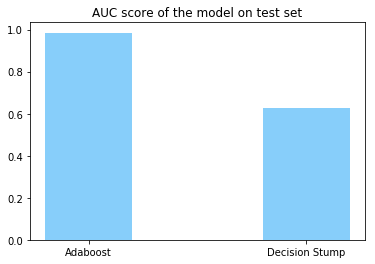

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.bar(np.array([1,2]), (score_abc, score_b1), 0.4,color='lightskyblue')
ax.set_xticks(np.array([1,2]))
ax.set_xticklabels(('Adaboost','Decision Stump'))
ax.set_title('AUC score of the model on test set')
plt.show()

The bar chart above shows that the adaboost performance much better than the decision stump classifier on the test dataset. The reason why the decision stump perform much worse is because it overfits the data and fail to classify the new testing data. If we increase the depth of the decision tree, the accuracy and the aoc score will be better, however, this chart still dispaly how Adaboost can make weak classifiers such as the decision stump to a strong classifier. It is also much less prone to overfitting than the decision tree model.

# Implementation of Adaboost
In this last section, I will implement a simple version of adaboost algorithm to help you understand the algorithm details more easily. Because the focus of this implementations are Adaboost algorithm, I will still use the decision tree classifiers as the weak classifiers.

In [38]:
import math
import copy
class Adaboost():
    
    classifier = None
    iterations = 100
    classifier_list = []
    significance_list = []
    def __init__(self, classifier, iterations):
        self.classifier = classifier
        self.iterations = iterations
        self.classifier_list = []
        self.significance_list = []
        
    def train(self, data, label, verbose=False):
        print ()
        print ("model training started")
        if len(data) != len(label):
            print ("data length does not match, abort")
            return
        weights = np.array([1] * len(data)).T
        weights = weights / weights.sum()
        for i in range(0, self.iterations):
            # train the weak classifier
            classifier = self.classifier.fit(data, label, sample_weight=weights)
            self.classifier_list.append(copy.deepcopy(classifier))
            # print (classifier)
            # calculate the error rate of the weak calssifier
            prediction = classifier.predict(data)
            correct = [0] * len(label)
            wrong = [0] * len(label)
            for j in range(0, len(label)):
                if label[j] == prediction[j]:
                    correct[j] = 1
                else:
                    wrong[j] = -1
            # note that the error is weighted
            error = - np.dot(np.array(wrong),(weights.T))
            if verbose == True:
                print("The weighted error of classifier "+ str(i) + " is " + str(error))

            # Calculate the weight of this weak classifier in the ensembled classifier 
            significance = math.log((1 - error) / error) / 2
            self.significance_list.append(significance)
            if verbose == True:
                print("The importance of classifier "+ str(i) + " is " + str(significance))

            # update the weights
            updated_para = np.exp(- significance * (np.array(correct) + np.array(wrong)).T )
            weights = weights * updated_para
            #normalize the weights
            weights = weights / weights.sum()
        print ("model training finished")
        print ()

    def predict(self, data, correct_label=None):
        sumprob = np.array([0.0] * len(data))
        
        for i in range(0, len(self.classifier_list)):
            #print(self.classifier_list[i].predict(data))
            # add all weak classifiers
            sumprob += self.significance_list[i] * self.classifier_list[i].predict(data)
        # print(sumprob)
        # sign(sum(all weak classifiers))
        res = []
        for j in sumprob:
            if j > 0:
                res.append(1)
            else:
                res.append(-1)
        if not correct_label is None:
            cnt = 0
            for k in range(0, len(correct_label)):
                if correct_label[k] != res[k]:
                    cnt += 1
            #print(cnt)
            print ("The accuracy of the prediction is "+ str(1 - cnt / len(correct_label)))
        return np.array(res)


After implementation, we can use the same data to train the model and get the accuracy to veify that the implementation is correcct.

In [39]:
test = Adaboost(benchmark1,50)
print ("train the model")
test.train(trainX, trainY)

test.predict(trainX, trainY)
test.predict(testX, testY)

train the model

model training started
model training finished

The accuracy of the prediction is 0.9727187446699642
The accuracy of the prediction is 0.9768286007526514


array([-1, -1, -1, ..., -1, -1, -1])

# Summary and more resources
This tutorial introduce the theory and the applications of the Adaboost algorithm. Adaboost is one of the most widely used boosting algorithm. Common appliances include face detection and recoginition, because the preformance of it is good interms of accuracy and runtime. I hope this tutorial can work as a first step of adaboost and boosting. If you are interested in diving deeper into it. You can check these papaers:
* [multi class Adaboost](https://www.intlpress.com/site/pub/files/_fulltext/journals/sii/2009/0002/0003/SII-2009-0002-0003-a008.pdf)
* [face detection application](http://www.inoa.it/home/cosimo/EI/adaboostforfacedetection.pdf)



<br> Apart from the Adaboost, other boosting algorithms also play very important role in the current macine learning area. Many Kaggle winner team will also use boosting such as Adaboost and [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) to ensemble the classifiers and achieve a high rank in the competition. [xgboost](https://github.com/dmlc/xgboost) is a library that most Kaggle winners are using to ensemble the model.

# Reference
[1] Freund, Y. (1995). Boosting a weak learning algorithm by majority. Information and computation, 121(2), 256-285.

[2] Cost-based Modeling and Evaluation for Data Mining With Application to Fraud and Intrusion Detection: Results from the JAM Project by Salvatore J. Stolfo, Wei Fan, Wenke Lee, Andreas Prodromidis, and Philip K. Chan. 

[3] Hastie, T., Rosset, S., Zhu, J., & Zou, H. (2009). Multi-class adaboost. Statistics and its Interface, 2(3), 349-360.
